In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, TimeDistributed

In [2]:
OUTPUT_DIR = '.'

In [3]:
batch_size = 32
img_height = 32
img_width = 32

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  validation_split=0.2,
  subset="training",
  seed=123,
  directory=os.path.join(OUTPUT_DIR, 'all_data'),
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4800 files belonging to 8 classes.
Using 3840 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  directory=os.path.join(OUTPUT_DIR, 'all_data'),
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4800 files belonging to 8 classes.
Using 960 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8']


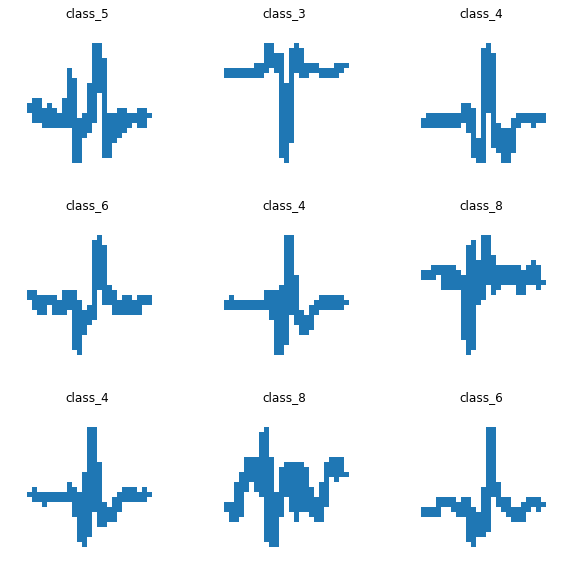

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 32, 32, 3)
(32,)


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
normalization_layer = layers.Rescaling(1./255)

In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.121568635 1.0


In [12]:
num_classes = len(class_names)

model = models.Sequential()

model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Flatten())
# encode rows of matrix
model.add(TimeDistributed(LSTM(128, activation='relu')))
model.add(Dropout(0.2))

# encode columns
model.add(LSTM(128, activation='relu'))

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(num_classes, activation='softmax'))


In [13]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 64)          1

In [15]:
epochs=100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
120/120 [==============================] - 25s 102ms/step - loss: 1.8471 - accuracy: 0.2570 - val_loss: 1.0206 - val_accuracy: 0.5854
Epoch 2/100
120/120 [==============================] - 7s 55ms/step - loss: 1.0064 - accuracy: 0.6016 - val_loss: 0.8327 - val_accuracy: 0.6406
Epoch 3/100
120/120 [==============================] - 6s 54ms/step - loss: 0.7967 - accuracy: 0.6836 - val_loss: 0.6882 - val_accuracy: 0.7448
Epoch 4/100
120/120 [==============================] - 6s 54ms/step - loss: 0.6548 - accuracy: 0.7508 - val_loss: 0.5539 - val_accuracy: 0.7875
Epoch 5/100
120/120 [==============================] - 5s 43ms/step - loss: 0.5499 - accuracy: 0.7878 - val_loss: 0.5171 - val_accuracy: 0.7979
Epoch 6/100
120/120 [==============================] - 6s 47ms/step - loss: 0.4860 - accuracy: 0.8062 - val_loss: 0.4317 - val_accuracy: 0.8240
Epoch 7/100
120/120 [==============================] - 6s 54ms/step - loss: 0.4225 - accuracy: 0.8310 - val_loss: 0.4560 - val_accurac

120/120 [==============================] - 8s 69ms/step - loss: 0.0223 - accuracy: 0.9937 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 58/100
120/120 [==============================] - 8s 69ms/step - loss: 0.0063 - accuracy: 0.9974 - val_loss: 6.8277e-05 - val_accuracy: 1.0000
Epoch 59/100
120/120 [==============================] - 7s 61ms/step - loss: 0.0121 - accuracy: 0.9969 - val_loss: 0.0430 - val_accuracy: 0.9917
Epoch 60/100
120/120 [==============================] - 7s 60ms/step - loss: 0.0426 - accuracy: 0.9891 - val_loss: 9.8894e-04 - val_accuracy: 1.0000
Epoch 61/100
120/120 [==============================] - 7s 61ms/step - loss: 0.0153 - accuracy: 0.9958 - val_loss: 4.3004e-04 - val_accuracy: 1.0000
Epoch 62/100
120/120 [==============================] - 8s 68ms/step - loss: 0.0058 - accuracy: 0.9982 - val_loss: 6.4116e-05 - val_accuracy: 1.0000
Epoch 63/100
120/120 [==============================] - 9s 73ms/step - loss: 3.4902e-04 - accuracy: 1.0000 - val_loss: 2.5199e-

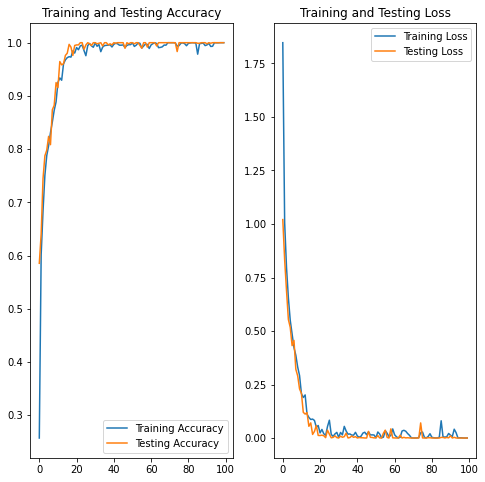

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Testing Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Testing Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Testing Loss')
plt.legend(loc='upper right')
plt.title('Training and Testing Loss')
plt.show()

In [17]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

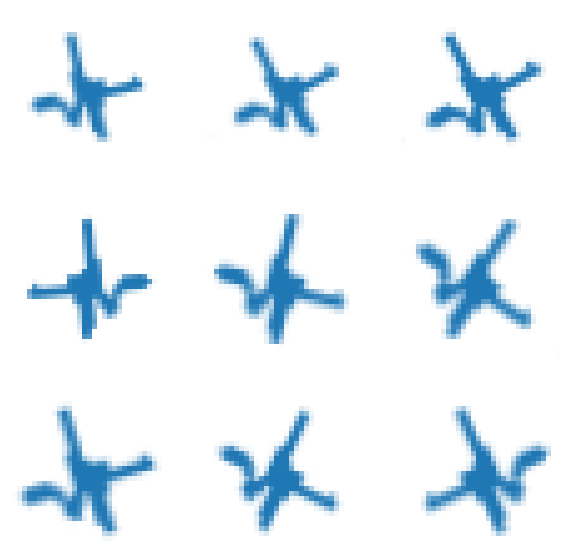

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [19]:
model = models.Sequential()

model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Flatten())
# encode rows of matrix
model.add(TimeDistributed(LSTM(128, activation='relu')))
model.add(Dropout(0.2))

# encode columns
model.add(LSTM(128, activation='relu'))

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(num_classes, activation='softmax'))

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 6, 6, 64)         

In [22]:
epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100


C:\Users\Kamoliddin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tensorflow\python\util\dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


120/120 [==============================] - 25s 70ms/step - loss: 1.8275 - accuracy: 0.2633 - val_loss: 1.0641 - val_accuracy: 0.5969
Epoch 2/100
120/120 [==============================] - 5s 44ms/step - loss: 1.0620 - accuracy: 0.5773 - val_loss: 0.9364 - val_accuracy: 0.6198
Epoch 3/100
120/120 [==============================] - 4s 33ms/step - loss: 0.8644 - accuracy: 0.6505 - val_loss: 0.7264 - val_accuracy: 0.7021
Epoch 4/100
120/120 [==============================] - 4s 32ms/step - loss: 0.7009 - accuracy: 0.7232 - val_loss: 0.6275 - val_accuracy: 0.7500
Epoch 5/100
120/120 [==============================] - 4s 33ms/step - loss: 0.6290 - accuracy: 0.7474 - val_loss: 0.5624 - val_accuracy: 0.7542
Epoch 6/100
120/120 [==============================] - 3s 29ms/step - loss: 0.5859 - accuracy: 0.7578 - val_loss: 0.6826 - val_accuracy: 0.7167
Epoch 7/100
120/120 [==============================] - 4s 31ms/step - loss: 0.5435 - accuracy: 0.7685 - val_loss: 0.4892 - val_accuracy: 0.7719
Epo

120/120 [==============================] - 3s 25ms/step - loss: 0.0158 - accuracy: 0.9951 - val_loss: 8.5326e-04 - val_accuracy: 1.0000
Epoch 58/100
120/120 [==============================] - 3s 24ms/step - loss: 0.0231 - accuracy: 0.9927 - val_loss: 8.1483e-04 - val_accuracy: 1.0000
Epoch 59/100
120/120 [==============================] - 3s 24ms/step - loss: 0.0167 - accuracy: 0.9935 - val_loss: 4.1329e-04 - val_accuracy: 1.0000
Epoch 60/100
120/120 [==============================] - 3s 24ms/step - loss: 0.0381 - accuracy: 0.9888 - val_loss: 0.0077 - val_accuracy: 0.9979
Epoch 61/100
120/120 [==============================] - 3s 24ms/step - loss: 0.0134 - accuracy: 0.9971 - val_loss: 2.2049e-04 - val_accuracy: 1.0000
Epoch 62/100
120/120 [==============================] - 3s 24ms/step - loss: 0.0168 - accuracy: 0.9943 - val_loss: 0.0033 - val_accuracy: 0.9990
Epoch 63/100
120/120 [==============================] - 3s 24ms/step - loss: 0.0458 - accuracy: 0.9878 - val_loss: 0.0012 - val

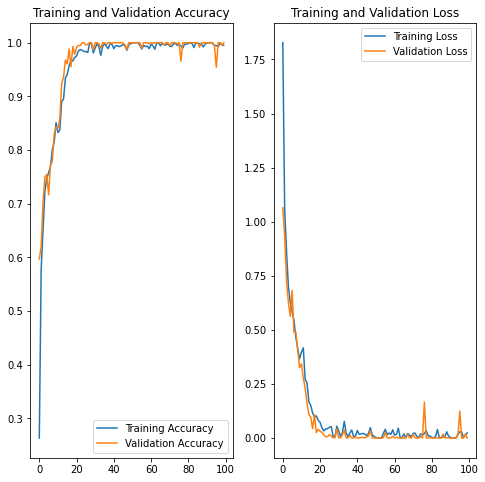

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint( filepath='weight.hdf5', save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True )

In [25]:
import glob

root_dir = "C:/Users/Kamoliddin/Desktop/CNN-LSTM classifier/test_data/"
for filename in glob.iglob(root_dir + '**/*.png', recursive=True):
    img = tf.keras.utils.load_img(
        filename, target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

This image most likely belongs to class_8 with a 27.03 percent confidence.
This image most likely belongs to class_4 with a 27.71 percent confidence.
This image most likely belongs to class_3 with a 27.42 percent confidence.
This image most likely belongs to class_1 with a 27.83 percent confidence.
This image most likely belongs to class_7 with a 21.91 percent confidence.
This image most likely belongs to class_3 with a 27.97 percent confidence.
This image most likely belongs to class_3 with a 25.51 percent confidence.
This image most likely belongs to class_3 with a 27.97 percent confidence.
This image most likely belongs to class_5 with a 25.02 percent confidence.
This image most likely belongs to class_4 with a 27.73 percent confidence.
This image most likely belongs to class_1 with a 27.97 percent confidence.
This image most likely belongs to class_1 with a 27.97 percent confidence.
This image most likely belongs to class_1 with a 27.97 percent confidence.
This image most likely be

This image most likely belongs to class_5 with a 23.52 percent confidence.
This image most likely belongs to class_5 with a 27.94 percent confidence.
This image most likely belongs to class_2 with a 27.97 percent confidence.
This image most likely belongs to class_3 with a 27.97 percent confidence.
This image most likely belongs to class_4 with a 24.07 percent confidence.
This image most likely belongs to class_3 with a 23.40 percent confidence.
This image most likely belongs to class_3 with a 16.56 percent confidence.
This image most likely belongs to class_6 with a 27.50 percent confidence.
This image most likely belongs to class_1 with a 27.96 percent confidence.
This image most likely belongs to class_2 with a 27.97 percent confidence.
This image most likely belongs to class_5 with a 27.96 percent confidence.
This image most likely belongs to class_7 with a 27.97 percent confidence.
This image most likely belongs to class_1 with a 27.97 percent confidence.
This image most likely be

This image most likely belongs to class_3 with a 27.97 percent confidence.
This image most likely belongs to class_6 with a 27.27 percent confidence.
This image most likely belongs to class_1 with a 27.97 percent confidence.
This image most likely belongs to class_2 with a 26.54 percent confidence.
This image most likely belongs to class_1 with a 27.96 percent confidence.
This image most likely belongs to class_1 with a 25.50 percent confidence.
This image most likely belongs to class_2 with a 20.94 percent confidence.
This image most likely belongs to class_4 with a 27.95 percent confidence.
This image most likely belongs to class_4 with a 27.51 percent confidence.
This image most likely belongs to class_1 with a 27.62 percent confidence.
This image most likely belongs to class_4 with a 27.95 percent confidence.
This image most likely belongs to class_3 with a 27.97 percent confidence.
This image most likely belongs to class_1 with a 26.91 percent confidence.
This image most likely be

This image most likely belongs to class_2 with a 27.97 percent confidence.
This image most likely belongs to class_4 with a 27.97 percent confidence.
This image most likely belongs to class_4 with a 20.59 percent confidence.
This image most likely belongs to class_3 with a 25.79 percent confidence.
This image most likely belongs to class_3 with a 27.97 percent confidence.
This image most likely belongs to class_3 with a 27.97 percent confidence.
This image most likely belongs to class_4 with a 27.97 percent confidence.
This image most likely belongs to class_4 with a 24.75 percent confidence.
This image most likely belongs to class_3 with a 27.97 percent confidence.
This image most likely belongs to class_1 with a 27.97 percent confidence.
This image most likely belongs to class_1 with a 27.97 percent confidence.
This image most likely belongs to class_2 with a 27.97 percent confidence.
This image most likely belongs to class_4 with a 27.96 percent confidence.
This image most likely be